In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
books = pd.read_csv('BX-Books.csv', sep=';', error_bad_lines=False, encoding="latin-1")
books.columns = ['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher', 'imageUrlS', 'imageUrlM', 'imageUrlL']
users = pd.read_csv('BX-Users.csv', sep=';', error_bad_lines=False, encoding="latin-1")
users.columns = ['userID', 'Location', 'Age']
ratings = pd.read_csv('BX-Book-Ratings.csv', sep=';', error_bad_lines=False, encoding="latin-1")
ratings.columns = ['userID', 'ISBN', 'bookRating']

b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping line 228957: expected 8 fields, saw 10\nSkipping line 245933: expected 8 fields, saw 9\nSkipping line 251296: expected 8 fields, saw 9\nSkipping line 259941: expected 8 fields, saw 9\nSkipping line 261529: expected 8 fields, saw 9\n'
/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3062: Dtyp

In [5]:
print(ratings.shape)
print(list(ratings.columns))

(1149780, 3)
['userID', 'ISBN', 'bookRating']


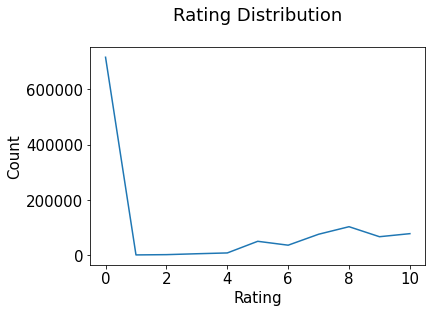

In [11]:
plt.rc("font", size=15)
ratings.bookRating.value_counts(sort=False).plot(kind='line')
plt.title('Rating Distribution\n')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.savefig('system1.png', bbox_inches='tight')
plt.show()


In [12]:
print(books.shape)
print(list(books.columns))

(271360, 8)
['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher', 'imageUrlS', 'imageUrlM', 'imageUrlL']


In [13]:
print(users.shape)
print(list(users.columns))

(278858, 3)
['userID', 'Location', 'Age']


Removing users with less than 50 ratings and Books with Less than 300 Ratings

In [14]:
counts1 = ratings['userID'].value_counts()
ratings = ratings[ratings['userID'].isin(counts1[counts1 >= 50].index)]
counts = ratings['bookRating'].value_counts()
ratings = ratings[ratings['bookRating'].isin(counts[counts >= 300].index)]



Using colaborative filtering model to reccomend books based on knn (A machine lerning algorithm which makes reccomendation based on nearest k neighbour

In [31]:
combine_book_rating = pd.merge(ratings, books, on='ISBN')
columns = ['yearOfPublication', 'publisher', 'imageUrlS', 'imageUrlM', 'imageUrlL']
combine_book_rating = combine_book_rating.drop(columns, axis=1)
combine_book_rating.head()

,userID,ISBN,bookRating,bookTitle,bookAuthor
0,276847,0446364193,0,Along Came a Spider (Alex Cross Novels),James Patterson
1,278418,0446364193,0,Along Came a Spider (Alex Cross Novels),James Patterson
2,5483,0446364193,0,Along Came a Spider (Alex Cross Novels),James Patterson
3,7346,0446364193,0,Along Came a Spider (Alex Cross Novels),James Patterson
4,8362,0446364193,0,Along Came a Spider (Alex Cross Novels),James Patterson


Grouping by book titles and creating a new column for data count

In [18]:
combine_book_rating = combine_book_rating.dropna(axis = 0, subset = ['bookTitle'])

book_ratingCount = (combine_book_rating.
     groupby(by = ['bookTitle'])['bookRating'].
     count().
     reset_index().
     rename(columns = {'bookRating': 'totalRatingCount'})
     [['bookTitle', 'totalRatingCount']]
    )
book_ratingCount.head()

,bookTitle,totalRatingCount
0,A Light in the Storm: The Civil War Diary of ...,4
1,Always Have Popsicles,1
2,Apple Magic (The Collector's series),1
3,"Ask Lily (Young Women of Faith: Lily Series, ...",1
4,Beyond IBM: Leadership Marketing and Finance ...,1


In [32]:
rating_with_totalRatingCount = combine_book_rating.merge(book_ratingCount, left_on = 'bookTitle', right_on = 'bookTitle', how = 'left')
rating_with_totalRatingCount.head()


,userID,ISBN,bookRating,bookTitle,bookAuthor,totalRatingCount
0,276847,0446364193,0,Along Came a Spider (Alex Cross Novels),James Patterson,198
1,278418,0446364193,0,Along Came a Spider (Alex Cross Novels),James Patterson,198
2,5483,0446364193,0,Along Came a Spider (Alex Cross Novels),James Patterson,198
3,7346,0446364193,0,Along Came a Spider (Alex Cross Novels),James Patterson,198
4,8362,0446364193,0,Along Came a Spider (Alex Cross Novels),James Patterson,198


In [20]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
print(book_ratingCount['totalRatingCount'].describe())

count   199187.000
mean         3.532
std         10.543
min          1.000
25%          1.000
50%          1.000
75%          3.000
max        852.000
Name: totalRatingCount, dtype: float64


In [30]:
print(book_ratingCount['totalRatingCount'].quantile(np.arange(.9, 1, .01)))

0.900    6.000
0.910    7.000
0.920    7.000
0.930    8.000
0.940    9.000
0.950   11.000
0.960   13.000
0.970   17.000
0.980   23.000
0.990   39.000
Name: totalRatingCount, dtype: float64


In [33]:
popularity_threshold = 75
rating_popular_book = rating_with_totalRatingCount.query('totalRatingCount >= @popularity_threshold')
rating_popular_book.head()


,userID,ISBN,bookRating,bookTitle,bookAuthor,totalRatingCount
0,276847,0446364193,0,Along Came a Spider (Alex Cross Novels),James Patterson,198
1,278418,0446364193,0,Along Came a Spider (Alex Cross Novels),James Patterson,198
2,5483,0446364193,0,Along Came a Spider (Alex Cross Novels),James Patterson,198
3,7346,0446364193,0,Along Came a Spider (Alex Cross Novels),James Patterson,198
4,8362,0446364193,0,Along Came a Spider (Alex Cross Novels),James Patterson,198


In [34]:
rating_popular_book.shape


(95482, 6)

# Since the data is particularly large, i am going to filter it to users of australia 

In [36]:
combined = rating_popular_book.merge(users, left_on = 'userID', right_on = 'userID', how = 'left')

australia_user_rating = combined[combined['Location'].str.contains("australia")]
australia_user_rating.head()



,userID,ISBN,bookRating,bookTitle,bookAuthor,totalRatingCount,Location,Age
20,30711,0446364193,0,Along Came a Spider (Alex Cross Novels),James Patterson,198,"sydney, new south wales, australia",32.000
58,86202,0446364193,0,Along Came a Spider (Alex Cross Novels),James Patterson,198,"sydney, new south wales, australia",26.000
74,109901,0446364193,6,Along Came a Spider (Alex Cross Novels),James Patterson,198,"sydney, new south wales, australia",59.000
106,149690,0446364193,0,Along Came a Spider (Alex Cross Novels),James Patterson,198,"logan city, queensland, australia",35.000
161,236340,0446364193,8,Along Came a Spider (Alex Cross Novels),James Patterson,198,"st kilda, victoria, australia",29.000


Implementing KNN

In [48]:
from scipy.sparse import csr_matrix
australia_user_rating = australia_user_rating.drop_duplicates(['userID', 'bookTitle'])
australia_user_rating_pivot = australia_user_rating.pivot(index = 'bookTitle', columns = 'userID', values = 'bookRating').fillna(0)
australia_user_rating_matrix = csr_matrix(australia_user_rating_pivot.values)

from sklearn.neighbors import NearestNeighbors


model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(australia_user_rating_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [51]:
australia_user_rating_pivot.iloc[query_index,:].values.reshape(1,-1)

array([[0., 0., 0., 0., 0., 0., 0., 8., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.]])

In [64]:
query_index = np.random.choice(australia_user_rating_pivot.shape[0])
print(query_index)
distances, indices = model_knn.kneighbors(australia_user_rating_pivot.iloc[query_index,:].values.reshape(1, -1), n_neighbors = 6)

245


In [52]:
australia_user_rating_pivot.index[query_index]


"Where the Heart Is (Oprah's Book Club (Paperback))"

In [60]:
for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for {0}:\n'.format(australia_user_rating_pivot.index[query_index]))
    else:
        print('{0}: {1}, with distance of {2}:'.format(i, australia_user_rating_pivot.index[indices.flatten()[i]], distances.flatten()[i]))

Recommendations for Where the Heart Is (Oprah's Book Club (Paperback)):

1: Where the Heart Is (Oprah's Book Club (Paperback)), with distance of 0.0:
2: Harry Potter and the Chamber of Secrets (Book 2), with distance of 0.0:
3: Harry Potter and the Order of the Phoenix (Book 5), with distance of 0.0:
4: Hemlock Bay, with distance of 0.0:
5: The Fellowship of the Ring (The Lord of the Rings, Part 1), with distance of 0.0:
